# Simulate Fermi system with heterostructures using MC

2024-11-18

As a proxy for a market with M mines and N power plants.

Start with a system of a few mines and two power plants.

In [8]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit, minimize, root

## 1. Minimal nontrivial system: 2 mines, 2 power plants

Tasks:
- implement working arrays
- implement buffer arrays


In [24]:
def selection_rules(i1, j1, i2, j2):
    '''Rules for indices to swap particles in MC exchange'''
    if i1 == i2 and j1 == j2:
        return False
    else:
        return True


def exp_bounding_fun(x):
    '''Prevent overflow in exponential'''
    return min(0, max(-100, x))


def compute_percentile(Ns, Es, perc, dN):
    '''compute real percentile with weights, Numpy function only available from Numpy 2.0'''
    buf = []
    for i, _ in enumerate(Ns):
        temp_weight = int(Ns[i] / dN)
        buf.extend([Es[i]] * temp_weight)

    return np.percentile(buf, perc, method='nearest')

In [63]:
# main fixed parameters
T = 0.1  # temperature

# raw production costs without 
Es = np.array([50, 80, 100, 110, 120] + list(range(130, 200, 10)))  # energy/cash cost levels, USD/t
Es = Es.astype(float)
# Es = np.array([50, 80, 100]).astype(float)

num_E = len(Es)
mat_Es = np.c_[Es, Es] # only two consumers
num_pp = 2  # number of power plants

# transport cost matrix
dE = 0.0  # fixed freight differential
mat_dE = np.ones_like(mat_Es) * dE
mat_Es += mat_dE

# volumes in Mt
N = 5.0
dN = 0.01

# Caps = np.array([1.0] * num_E)  # mine capacities, all same
Caps = np.array([0.5, 1.5, 2.0, 0.75, 0.5, 1.0, 0.25, 0.25, 0.5, 0.5, 1.0, 1.0])
# Caps = np.array([1.0, 1.0, 1.0])
mat_Caps = np.c_[Caps, Caps]

# Ns = np.array([0.0] * 7 + [1.0] * 5)  # manual initial allocation of volumes
Ns = np.array([0.0] * (num_E-1) + [N/2])  # simplest initial allocation, but need more steps
mat_Ns = np.c_[Ns, Ns]

In [64]:
%%time

np.random.seed(43)
DEBUG = False
THERMO = 100

# MC simulation
n_steps = int(5e3)
n_sim = int(1e3)  # simulation steps after equilibration
n_eq = n_steps - n_sim  # equilibration steps

# simulation buffers
energies = []
prices = []
avg_Es = np.zeros_like(mat_Es)
avg_Ns = np.zeros_like(mat_Ns)

n_swap = 0  # number of successful swaps

print('step n_swap E dE P')
for step in range(n_steps+1):
    # select proper levels
    while True:
        # transfer dN from (i1, j1) to (i2, j2)
        i1 = np.random.randint(num_E)
        j1 = np.random.randint(num_pp)
        i2 = np.random.randint(num_E)
        j2 = np.random.randint(num_pp)
        if selection_rules(i1, j1, i2, j2) and mat_Ns[i1, j1] > 0 and mat_Ns[i2, j2] < mat_Caps[i2, j2]:
            break
    if DEBUG:
        print(i1, j1, i2, j2)

    # swap particles
    mat_Ns[i1, j1] -= dN
    mat_Ns[i2, j2] += dN
    dE = mat_Es[i2, j2] - mat_Es[i1, j1]
    if DEBUG:
        print(dE)

    # perform Metropolis step, return to orign conf, prevent overflow in exp
    if np.exp(exp_bounding_fun(-dE/T)) <= np.random.rand():
        # reject
        mat_Ns[i1, j1] += dN
        mat_Ns[i2, j2] -= dN
    else:
        # accept
        n_swap += 1
    
    # compute observables
    E = (mat_Ns * mat_Es).sum()  # total energy
    P = np.zeros(num_pp)
    for j in range(num_pp):
        P[j] = compute_percentile(mat_Ns[:, j], mat_Es[:, j], 90, dN)
    energies.append(E)
    prices.append(P)
    if step >= n_eq:
        avg_Ns += mat_Ns

    if step % THERMO == 0:
        print(step, n_swap, E, dE, P)

# post-process
avg_Ns = avg_Ns / n_sim

step n_swap E dE P
0 1 949.1 -90.0 [190. 190.]
100 47 923.500000000001 30.0 [190. 190.]
200 97 899.4000000000019 80.0 [190. 190.]
300 136 882.0000000000026 -10.0 [190. 190.]
400 169 866.900000000003 50.0 [190. 190.]
500 209 845.7000000000037 70.0 [190. 190.]
600 247 823.200000000004 70.0 [190. 190.]
700 288 803.600000000004 40.0 [190. 190.]
800 328 782.800000000004 120.0 [190. 190.]
900 376 755.900000000004 70.0 [190. 190.]
1000 407 740.1000000000039 60.0 [190. 190.]
1100 452 720.5000000000039 20.0 [190. 190.]
1200 499 704.500000000004 20.0 [190. 190.]
1300 535 689.1000000000039 -70.0 [190. 190.]
1400 575 674.9000000000038 -60.0 [190. 190.]
1500 623 659.8000000000038 60.0 [190. 190.]
1600 667 642.1000000000038 -110.0 [190. 190.]
1700 710 627.5000000000038 80.0 [190. 190.]
1800 748 612.6000000000038 70.0 [190. 190.]
1900 776 601.6000000000038 -50.0 [190. 190.]
2000 806 588.1000000000038 -80.0 [190. 190.]
2100 839 576.6000000000038 -10.0 [190. 190.]
2200 874 563.3000000000038 50.0 [190. 

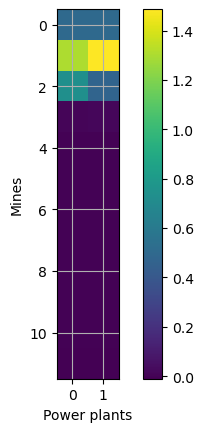

In [65]:
# plot distribution
plt.imshow(avg_Ns)
plt.xlabel('Power plants')
plt.ylabel('Mines')
plt.colorbar()
plt.grid()

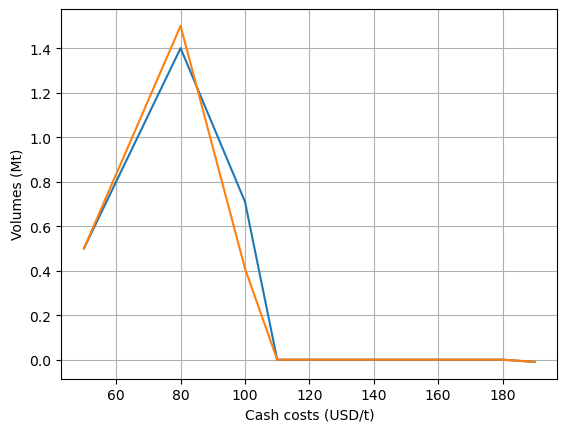

In [68]:
for j in range(num_pp):
    plt.plot(mat_Es[:, j], mat_Ns[:, j])

plt.xlabel('Cash costs (USD/t)')
plt.ylabel('Volumes (Mt)')
plt.grid()